In [ ]:
##Without improvment

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
episode: 74/100, score: -2.265055298805237
1/1 [==============================] - 0s 23ms/step
episode: 75/100, score: -2.0056975185871124
1/1 [==============================] - 0s 19ms/step
episode: 76/100, score: -0.5067117810249329
1/1 [==============================] - 0s 25ms/step
episode: 77/100, score: -3.154796749353409
1/1 [==============================] - 0s 22ms/step
episode: 78/100, score: -0.8338219821453094
1/1 [==============================] - 0s 22ms/step
episode: 79/100, score: -0.7678718864917755
1/1 [==============================] - 0s 35ms/step
episode: 80/100, score: -1.6587062776088715
1/1 [==============================] - 0s 25ms/step
episode: 81/100, score: -0.43268632888793945
1/1 [==============================] - 0s 23ms/step
episode: 82/100, score: -1.9666748344898224
1/1 [==============================] - 0s 36ms/step
episode: 83/100, score: -0.3162159

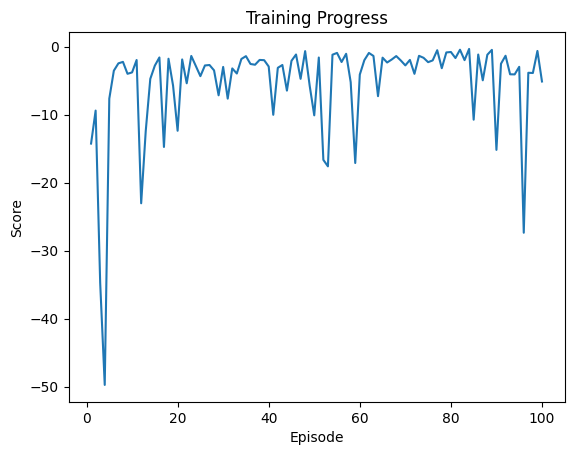

In [ ]:
import numpy as np
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt


class DeepQNetwork:
    def __init__(self, action_space, state_space, learning_rate=0.001):
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.99
        self.batch_size = 64
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=2000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_space_shape, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_space_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def rememberFunction(self, state, action, reward, nextState, done):
        state = np.array(state).reshape(self.state_space_shape)
        nextState = np.array(nextState).reshape(self.state_space_shape)
        self.memory.append((state, action, reward, nextState, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.expand_dims(state, axis=0)
        actValues = self.model.predict(state)
        return np.argmax(actValues[0])

    def replayFunction(self):
        if len(self.memory) < self.batch_size:
            return
        miniBatchVar = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in miniBatchVar])
        actions = np.array([i[1] for i in miniBatchVar])
        rewards = np.array([i[2] for i in miniBatchVar])
        nextStates = np.array([i[3] for i in miniBatchVar])
        dones = np.array([i[4] for i in miniBatchVar])

        targets = rewards + self.gamma * np.amax(self.target_model.predict_on_batch(nextStates), axis=1) * (1 - dones)

        target_full = self.model.predict_on_batch(states)

        target_full[np.arange(self.batch_size), actions] = targets

        self.model.fit(states, target_full, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def soft_update_target_network(self, tau):
        model_weights = self.model.get_weights()
        target_model_weights = self.target_model.get_weights()

        new_weights = []
        for model_weight, target_model_weight in zip(model_weights, target_model_weights):
            new_weight = tau * model_weight + (1 - tau) * target_model_weight
            new_weights.append(new_weight)

        self.target_model.set_weights(new_weights)


def rewardFunction(nextStateInfo):
    position, velocity = nextStateInfo[0]  # Extract position and velocity
    reward = np.abs(position - (-0.5))  # Reward based on distance from the goal
    return -reward  # Negative reward to encourage reaching the goal


def trainDQNetwork(environment, agent, episode):
    episodeScores = []
    for e in range(episode):
        state = environment.reset()
        score = 0
        maxSteps = 1000
        for i in range(maxSteps):
            state = np.array(state)
            action = agent.act(state)
            stepResult = environment.step(action)
            nextState, _, done, _ = stepResult
            reward = rewardFunction(stepResult)
            score += reward
            nextState = np.array(nextState)
            agent.rememberFunction(state, action, reward, nextState, done)
            state = nextState
            agent.replayFunction()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        episodeScores.append(score)
        agent.soft_update_target_network(0.001)  # Soft update the target network
    return episodeScores


def main():
    environment = gym.make('MountainCar-v0', render_mode=None)
    np.random.seed(10)

    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape[0], learning_rate=0.001)
    episodes = 100
    episodeScores = trainDQNetwork(environment, agent, episodes)
    plt.plot([i + 1 for i in range(episodes)], episodeScores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Training Progress')
    plt.show()


if __name__ == '__main__':
    main()


In [ ]:
##double QN

In [ ]:
import numpy as np
import pygame
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DeepQNetwork:

    def __init__(self, action_space, state_space, learning_rate=0.001):
        # Initialize Deep Q-Network parameters
        self.epsilon = 1.0
        self.gamma = 0.95
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.learning_rate = learning_rate
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=100000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()
        self.target_model = self.build_model()  # Add target network

    def build_model(self):
        # Build the neural network model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space_shape[0], activation=relu))
        model.add(Dense(25, activation=relu))
        model.add(Dense(self.action_space_size, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def rememberFunction(self, state, action, reward, nextState, done):
        # Remember the experience (state, action, reward, next_state, done)
        state = np.array(state)
        nextState = np.array(nextState)
        state = np.reshape(state, [1, self.state_space_shape[0]])  # Reshape state
        nextState = np.reshape(nextState, [1, self.state_space_shape[0]])  # Reshape next state
        self.memory.append((state, action, reward, nextState, done))

    def act(self, state):
        # Choose an action based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.expand_dims(state, axis=0)
        actValues = self.model.predict(state)
        return np.argmax(actValues[0])

    def replayFunction(self):
        # Experience replay to train the model
        if len(self.memory) < self.batch_size:
            return

        miniBatchVar = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in miniBatchVar])
        actions = np.array([i[1] for i in miniBatchVar])
        rewards = np.array([i[2] for i in miniBatchVar])
        nextStates = np.array([i[3] for i in miniBatchVar])
        dones = np.array([i[4] for i in miniBatchVar])

        # Double DQN: Use target network to select best actions
        q_values_next = self.target_model.predict_on_batch(nextStates)
        actions_next = np.argmax(self.model.predict_on_batch(nextStates), axis=1)
        targets = rewards + self.gamma * q_values_next[np.arange(self.batch_size), actions_next] * (1 - dones)

        targetsFull = self.model.predict_on_batch(states)

        indexes = np.array([i for i in range(self.batch_size)])
        targetsFull[[indexes], [actions]] = targets

        self.model.fit(states, targetsFull, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        # Update target network weights
        self.target_model.set_weights(self.model.get_weights())


def rewardFunction(nextStateInfo):
    # Define the reward function based on the next state
    nextState = nextStateInfo[0]  # Extracting the next state array
    if nextState[0] >= 0.5:
        print("Car reached the top")
        return 10
    if nextState[0] > -0.4:
        return (1 + nextState[0]) ** 2
    return 0


def trainDQNetwork(environment, agent, episode):
    # Training the Deep Q-Network
    episodeScores = []
    for e in range(episode):
        state = environment.reset()[0]  # Extracting the state array
        score = 0
        maxSteps = 1000
        for i in range(maxSteps):
            state = np.array(state)
            action = agent.act(state)
            stepResult = environment.step(action)  # Get all return values
            nextState, reward, done = stepResult[:3]  # Get the first three elements
            reward = rewardFunction(stepResult)  # Pass values to rewardFunction function
            score += reward
            nextState = np.array(nextState)
            agent.rememberFunction(state, action, reward, nextState, done)
            state = nextState
            agent.replayFunction()
            if done:
                print("Episode: {}/{}, score: {}".format(e, episode, score))
                break
        episodeScores.append(score)
        agent.update_target_model()  # Update target network
    return episodeScores


def main():
    pygame.init()  # Initialize Pygame
    environment = gym.make('MountainCar-v0', render_mode="human")  # Render as human
    np.random.seed(10)  # Numpy random seed

    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape, learning_rate=0.001)
    episodes = 100
    episodeScores = trainDQNetwork(environment, agent, episodes)
    plt.plot([i + 1 for i in range(episodes)], episodeScores)
    plt.show()


if __name__ == '__main__':
    main()


Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


ValueError: cannot reshape array of size 1 into shape (1,2)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Episode: 74/100, score: 53.115058768702795
1/1 [==============================] - 0s 32ms/step
Episode: 75/100, score: 52.47077700101891
1/1 [==============================] - 0s 22ms/step
Episode: 76/100, score: 49.4709000035605
1/1 [==============================] - 0s 43ms/step
Episode: 77/100, score: 45.890967477613714
1/1 [==============================] - 0s 26ms/step
Episode: 78/100, score: 49.77223405983017
1/1 [==============================] - 0s 25ms/step
Episode: 79/100, score: 180.37538475026955
1/1 [==============================] - 0s 22ms/step
Episode: 80/100, score: 51.33444788413848
1/1 [==============================] - 0s 19ms/step
Episode: 81/100, score: 51.72677766175154
1/1 [==============================] - 0s 24ms/step
Episode: 82/100, score: 57.23456706351313
1/1 [==============================] - 0s 19ms/step
Episode: 83/100, score: 57.83399879013563
1/1 [==

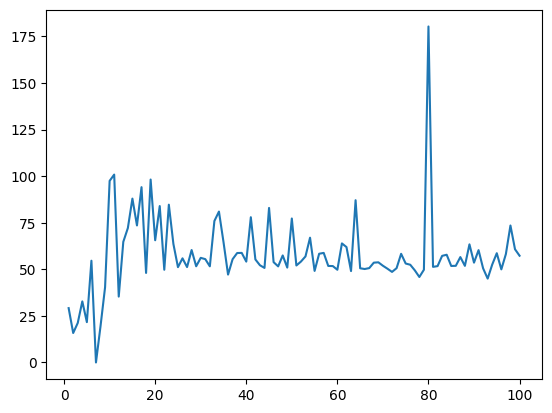

In [ ]:
import numpy as np
import pygame
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DeepQNetwork:

    def __init__(self, action_space, state_space, learning_rate=0.001):
        # Initialize Deep Q-Network parameters
        self.epsilon = 1.0
        self.gamma = 0.95
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.learning_rate = learning_rate
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=100000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()
        self.target_model = self.build_model()  # Add target network

    def build_model(self):
        # Build the neural network model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space_shape[0], activation=relu))
        model.add(Dense(25, activation=relu))
        model.add(Dense(self.action_space_size, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def rememberFunction(self, state, action, reward, nextState, done):
        # Remember the experience (state, action, reward, next_state, done)
        self.memory.append((state, action, reward, nextState, done))

    def act(self, state):
        # Choose an action based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.reshape(state, (1, -1))
        actValues = self.model.predict(state)
        return np.argmax(actValues[0])

    def replayFunction(self):
        # Experience replay to train the model
        if len(self.memory) < self.batch_size:
            return

        miniBatchVar = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in miniBatchVar])
        actions = np.array([i[1] for i in miniBatchVar])
        rewards = np.array([i[2] for i in miniBatchVar])
        nextStates = np.array([i[3] for i in miniBatchVar])
        dones = np.array([i[4] for i in miniBatchVar])

        # Double DQN: Use target network to select best actions
        q_values_next = self.target_model.predict_on_batch(nextStates)
        actions_next = np.argmax(self.model.predict_on_batch(nextStates), axis=1)
        targets = rewards + self.gamma * q_values_next[np.arange(self.batch_size), actions_next] * (1 - dones)

        targetsFull = self.model.predict_on_batch(states)

        indexes = np.array([i for i in range(self.batch_size)])
        targetsFull[[indexes], [actions]] = targets

        self.model.fit(states, targetsFull, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        # Update target network weights
        self.target_model.set_weights(self.model.get_weights())


def rewardFunction(nextStateInfo):
    # Define the reward function based on the next state
    nextState = nextStateInfo[0]  # Extracting the next state array
    if nextState[0] >= 0.5:
        print("Car reached the top")
        return 10
    if nextState[0] > -0.4:
        return (1 + nextState[0]) ** 2
    return 0


def trainDQNetwork(environment, agent, episode):
    # Training the Deep Q-Network
    episodeScores = []
    for e in range(episode):
        state = environment.reset()  # Extracting the state array
        score = 0
        maxSteps = 1000
        for i in range(maxSteps):
            state = np.array(state)
            action = agent.act(state)
            stepResult = environment.step(action)  # Get all return values
            nextState, reward, done = stepResult[:3]  # Get the first three elements
            reward = rewardFunction(stepResult)  # Pass values to rewardFunction function
            score += reward
            nextState = np.array(nextState)
            agent.rememberFunction(state, action, reward, nextState, done)
            state = nextState
            agent.replayFunction()
            if done:
                print("Episode: {}/{}, score: {}".format(e, episode, score))
                break
        episodeScores.append(score)
        agent.update_target_model()  # Update target network
    return episodeScores


def main():
    pygame.init()  # Initialize Pygame
    environment = gym.make('MountainCar-v0', render_mode="human")  # Render as human
    np.random.seed(10)  # Numpy random seed

    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape, learning_rate=0.001)
    episodes = 100
    episodeScores = trainDQNetwork(environment, agent, episodes)
    plt.plot([i + 1 for i in range(episodes)], episodeScores)
    plt.show()


if __name__ == '__main__':
    main()

In [ ]:
##TARGET IMPROVMENT

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
episode: 74/100, score: 7.46
1/1 [==============================] - 0s 38ms/step
episode: 75/100, score: 0.00
1/1 [==============================] - 0s 23ms/step
episode: 76/100, score: 0.00
1/1 [==============================] - 0s 35ms/step
episode: 77/100, score: 10.72
1/1 [==============================] - 0s 24ms/step
episode: 78/100, score: 0.00
1/1 [==============================] - 0s 40ms/step
episode: 79/100, score: 0.00
1/1 [==============================] - 0s 37ms/step
episode: 80/100, score: 10.36
1/1 [==============================] - 0s 23ms/step
episode: 81/100, score: 22.84
1/1 [==============================] - 0s 29ms/step
episode: 82/100, score: 12.96
1/1 [==============================] - 0s 24ms/step
episode: 83/100, score: 0.00
1/1 [==============================] - 0s 30ms/step
episode: 84/100, score: 12.61
1/1 [==============================] - 0s 51ms/step
e

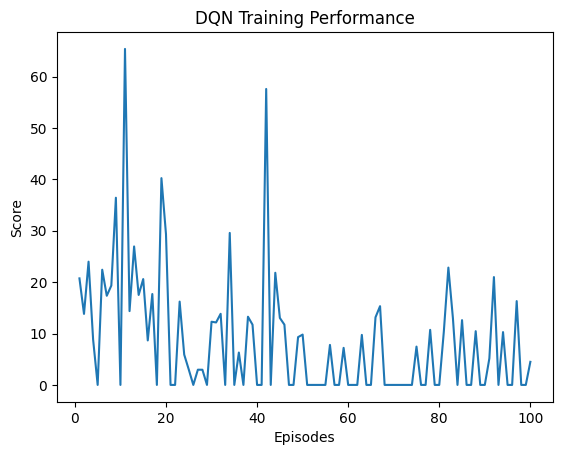

In [ ]:
import numpy as np
import pygame
import time
import gym
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import relu, linear
from collections import deque

class DeepQNetwork:
    def __init__(self, action_space, state_space, learning_rate=0.001):
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.gamma = 0.99
        self.batch_size = 128
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=200000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_space_shape, activation=relu))
        model.add(Dense(128, activation=relu))
        model.add(Dense(64, activation=relu))
        model.add(Dense(self.action_space_size, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        state = np.ravel(state)
        next_state = np.ravel(next_state)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.ravel(state)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        mini_batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for sample in mini_batch:
            state, action, reward, next_state, done = sample
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)
        targets = rewards + self.gamma * np.amax(self.target_model.predict_on_batch(next_states), axis=1) * (1 - dones)
        target_full = self.model.predict_on_batch(states)
        target_full[np.arange(self.batch_size), actions] = targets
        self.model.fit(states, target_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def soft_update_target_network(self, tau):
        model_weights = self.model.get_weights()
        target_model_weights = self.target_model.get_weights()
        new_weights = []
        for model_weight, target_model_weight in zip(model_weights, target_model_weights):
            new_weight = tau * model_weight + (1 - tau) * target_model_weight
            new_weights.append(new_weight)
        self.target_model.set_weights(new_weights)

def reward_function(next_state_info):
    next_state = next_state_info[0]
    if next_state[0] >= 0.5:
        return 10
    if next_state[0] > -0.4:
        return (1 + next_state[0]) ** 2
    return 0

def train_dqn(environment, agent, episodes):
    episode_scores = []
    for e in range(episodes):
        state = environment.reset()
        state = np.array(state)
        score = 0
        max_steps = 1000
        for _ in range(max_steps):
            if state.shape != (agent.state_space_shape,):
                state = np.zeros(agent.state_space_shape)
            action = agent.act(state)
            step_result = environment.step(action)
            next_state, reward, done = step_result[:3]
            reward = reward_function(step_result)
            score += reward
            next_state = np.array(next_state)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {:.2f}".format(e, episodes, score))
                break
        episode_scores.append(score)
        agent.soft_update_target_network(0.01)
    return episode_scores

def main():
    pygame.init()
    environment = gym.make('MountainCar-v0')
    np.random.seed(10)
    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape[0], learning_rate=0.0001)
    episodes = 100
    episode_scores = train_dqn(environment, agent, episodes)
    plt.plot([i + 1 for i in range(len(episode_scores))], episode_scores)
    plt.xlabel('Episodes')
    plt.ylabel('Score')
    plt.title('DQN Training Performance')
    plt.show()

if __name__ == '__main__':
    main()